# Lab 5: Agentic Document Extraction for RAG

In this lab, you will build a Retrieval-Augmented Generation (RAG) pipeline using ADE. RAG enables LLMs to answer questions about documents by retrieving relevant chunks and generating answers grounded in that context.

**Learning Objectives:**
- Understand the three phases of RAG: Preprocess, Retrieve, and Generate
- Set up a local ChromaDB vector database with OpenAI embeddings
- Incorporate visual grounding into queries for traceable information retrieval

## Background

Traditional keyword search fails when questions don't match exact document wording. RAG implements semantic search in three parts:
1. Preprocess: Parse documents into chunks, embed as vectors, store in database
2. Retrieve: Convert query to vector, find semantically similar chunks
3. Generate: Pass retrieved chunks as context to LLM for grounded answers

You will work with Apple's 10-K SEC filing (74 pages) pre-parsed using ADE (453 chunks). Each chunk includes text, bounding box coordinates, page number, and chunk type (eg text, table, figure).

## Outline

- [1. Import Libraries](#1)
- [2. Loading ADE-Parsed Data](#2)
- [3. Setting up the Vector Database](#3)
- [4. Querying the Database](#4)
- [5. Hybrid Search](#5)
- [6. RAG with LangChain](#6)

<a id="1"></a>

## 1. Import Libraries

Load libraries:

- **openai**: Generate vector embeddings (`text-embedding-3-small`)
- **chromadb**: Vector database for storing and querying embeddings
- **langchain**: Framework for building RAG chains

Additionally we have a script `helper.py` containing some utilities for cropping images and superimposing bounding boxes.  

In [1]:
import os
import json
import re
from pathlib import Path
from dotenv import load_dotenv

from IPython.display import display, Image, IFrame, Markdown, JSON 

import helper

# OpenAI & ChromaDB - Embedding + Vector Store
import openai
import chromadb

# Langchain 
from langchain.chains import create_retrieval_chain
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.vectorstores import Chroma

# Load environment variables from .env
_ = load_dotenv(override=True)

<a id="2"></a>

## 2. Loading ADE-Parsed Data

The Apple 10-K document has been pre-parsed using ADE. The output includes:
- Markdown: Full document converted to structured markdown with anchor tags
- JSON: Individual content chunks with metadata (bounding boxes, page numbers, chunk types)

This pre-computed output lets you focus on the RAG pipeline. In production, you would call the ADE Parse API directly.

In [2]:
DOC_PATH = Path("apple_10k.pdf")
helper.print_document(DOC_PATH)

Set up paths to the pre-computed ADE outputs:

In [3]:
# Setting Directories and Paths
OUTPUT_DIR = Path("./ade_outputs")
ADE_JSON_PATH = OUTPUT_DIR / "apple_10k_chunks.json"  
ADE_MD_PATH = OUTPUT_DIR / "apple_10k.md"

Preview the parsed markdown. Notice the anchor IDs which linking extracted information back to source locations.

In [4]:
# Load and display markdown preview
print("\n Parsed Output (Page 1):")
with open(ADE_MD_PATH, "r", encoding="utf-8") as f:
    markdown_content = f.read()
    # Find first page content (up to first page break or 500 chars)
    first_page = markdown_content[:500]
    print(first_page + "...")


 Parsed Output (Page 1):
<a id='c7665222-d689-4091-bc9b-9eb9e3e36445'></a>

UNITED STATES
SECURITIES AND EXCHANGE COMMISSION
Washington, D.C. 20549

<a id='14df885b-2c55-4acd-9224-b83fc8b36ee8'></a>

FORM 10-K

---

<a id='8eb83744-4c60-470a-adb1-f480d6d855c3'></a>

(Mark One)

option ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934: [x]
For the fiscal year ended September 30, 2023
or
option TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934: [ ]
...


Load the JSON chunks. Each chunk contains:
- `chunk_id`: Unique identifier (matches anchor IDs in markdown)
- `chunk_type`: "text", "table", or "figure"
- `text`: The actual content
- `bbox`: Bounding box coordinates `[x0, y0, x1, y1]` (normalized 0-1)
- `page`: Page number (0-indexed)

In [5]:
# Load the existing JSON chunks
with open(ADE_JSON_PATH, "r", encoding="utf-8") as f:
    loaded_chunks = json.load(f)

print(f"Loaded {len(loaded_chunks)} saved chunks.")

# Show first chunk structure
print(f"\n Sample chunk structure:")
print(json.dumps(loaded_chunks[0], indent=2)[:400] + "...")

print("\n Ready to query!")

Loaded 453 saved chunks.

 Sample chunk structure:
{
  "chunk_id": "c7665222-d689-4091-bc9b-9eb9e3e36445",
  "chunk_type": "text",
  "text": "<a id='c7665222-d689-4091-bc9b-9eb9e3e36445'></a>\n\nUNITED STATES\nSECURITIES AND EXCHANGE COMMISSION\nWashington, D.C. 20549",
  "bbox": [
    0.267689049243927,
    0.11527088284492493,
    0.7325717806816101,
    0.17836156487464905
  ],
  "page": 0
}...

 Ready to query!


<a id="3"></a>

## 3. Setting up the Vector Database

Set up ChromaDB to store vector embeddings. ChromaDB is a lightweight vector database that supports:
- **HNSW indexing**: Fast approximate nearest neighbor search
- **Metadata filtering**: Query by chunk type, page number, etc.
- **Persistence**: Data survives kernel restarts

You will use OpenAI's `text-embedding-3-small` to convert text into 1536-dimensional vectors.

In [6]:
# Setting Directory and Collectioon name
CHROMA_DB_PATH = Path("./chroma_db")
COLLECTION_NAME = "ade_documents"

# embeding model for vector database 
EMBEDDING_MODEL = "text-embedding-3-small"

# Instantiate the Chroma Client
chroma_client = chromadb.PersistentClient(path=CHROMA_DB_PATH)

# Create or Load ADE Collection
collection = chroma_client.get_or_create_collection(name=COLLECTION_NAME)

Check if chunks are already in the database from a previous run:

In [7]:
print(f"Checking for existing chunks in Chroma...")

# Get all existing chunk IDs from the collection
existing_result = collection.get(
                    ids=[chunk["chunk_id"] for chunk in loaded_chunks])
existing_ids = set(existing_result.get('ids', []))
print(f"Found {len(existing_ids)} existing chunks in collection")

Checking for existing chunks in Chroma...
Found 453 existing chunks in collection


For each new chunk, generate an embedding and store it with metadata:
- `chunk_type`: Filter by content type (text vs. table)
- `page`: Filter by page number
- `bbox_*`: Bounding box coordinates for visual grounding

In [8]:
print(f"Inserting new chunks into Chroma...")

added_count = 0
for i, chunk in enumerate(loaded_chunks):
    chunk_id = chunk["chunk_id"]
    
    # Add chunk if it does not exist
    if chunk_id not in existing_ids:
        text = chunk.get("text", "")
        
        # Skip empty chunks
        if not text or not text.strip():
            continue

        # Generate Embeddings for chunk text with OpenAI
        emb = openai.embeddings.create(
            input=text,
            model=EMBEDDING_MODEL
        ).data[0].embedding
        
        # Flatten Metadata (Simple Types Only)
        metadata = {
            "chunk_type": chunk.get("chunk_type", "unknown"),
            "page": chunk.get("page", 0)
        }
        
        # Add bbox coordinates to metadata
        bbox = chunk.get("bbox")
        if bbox and len(bbox) == 4:
            metadata["bbox_x0"] = float(bbox[0])
            metadata["bbox_y0"] = float(bbox[1])
            metadata["bbox_x1"] = float(bbox[2])
            metadata["bbox_y1"] = float(bbox[3])
        
        # Store in Chroma
        collection.add(
            documents=[text],
            ids=[chunk_id],
            metadatas=[metadata],
            embeddings=[emb]
        )
        
        added_count += 1
        
        # Progress indicator
        if (added_count) % 20 == 0:
            print(f"   Processed {added_count} new chunks...")

print(f"\n✓ Added {added_count} new chunks, skipped existing chunks")

Inserting new chunks into Chroma...

✓ Added 0 new chunks, skipped existing chunks


<a id="4"></a>

## 4. Querying the Database

Create a function to query the vector database:
1. Embed the query: Convert question to vector
2. Similarity search: Find chunks closest to query vector
3. Filter by threshold: Return only results above minimum similarity
4. Visual grounding: Display cropped images of source chunks

Similarity score is `1 - distance`, where distance is the L2 (Euclidean) distance between vectors.

In [9]:
def rag_query(question, top_k=3, threshold=0.25, show_images=True):
    """
    Query the ADE Chroma index with a natural language question.
    Dynamically extracts and displays JUST the relevant chunk from 
    the PDF.
    
    Args:
        question (str): User query
        top_k (int): Max results to return
        threshold (float): Minimum similarity (1 - distance)
        show_images (bool): Display chunk-level grounding visualizations
    """
    # 1. Embed Query
    q_embed = openai.embeddings.create(
        model=EMBEDDING_MODEL,
        input=question
    ).data[0].embedding

    # 2. Query Chroma
    results = collection.query(
        query_embeddings=[q_embed],
        n_results=top_k,
        include=["documents", "metadatas", "distances"]
    )

    print(f"\n Query: {question}\n")
    print("=" * 80)

    # 3. Parse Results
    retrieved_docs = results["documents"][0]
    retrieved_meta = results["metadatas"][0]
    retrieved_dists = results["distances"][0]
    retrieved_ids = results["ids"][0]

    found_any = False
    for i, (text, meta, dist, cid) in enumerate(zip(
        retrieved_docs, retrieved_meta, retrieved_dists, retrieved_ids
    )):
        similarity = 1 - dist
         # Skip Weak Matches
        if similarity >= threshold:
            
            found_any = True
            page_num = meta.get('page', 0)
            chunk_type = meta.get('chunk_type', 'unknown')
            
            print(f"\n  Result {i+1} (similarity={similarity:.3f}):")
            print(f"   Chunk ID: {cid}")
            print(f"   Type: {chunk_type}, Page: {page_num}" )
            print(f"   Text preview: {text[:200]}...")
            
            # Display chunk-level grounding image
            if show_images:
                # Extract bbox from metadata if available
                bbox = None
                if all(k in meta for k in ['bbox_x0', 'bbox_y0', 'bbox_x1', 'bbox_y1']):
                    bbox = [
                        meta['bbox_x0'],
                        meta['bbox_y0'],
                        meta['bbox_x1'],
                        meta['bbox_y1']
                    ]
                
                # Dynamically extract chunk image from PDF
                print(f"\n Dynamically extracting chunk from PDF...")
                chunk_img = helper.extract_chunk_image(
                    pdf_path=DOC_PATH,
                    page_num=page_num,
                    bbox=bbox,
                    highlight=True,
                    padding=10
                )
                
                if chunk_img:
                    print(f"{chunk_type.title()} chunk (cropped):")
                    display(Image(data=chunk_img))
                else:
                    print(f"Could not extract chunk image")
          
        
        print("-" * 80)

    if not found_any:
        print("No results above similarity threshold.")
    
    return results


print("RAG query function defined with dynamic chunk extraction")

RAG query function defined with dynamic chunk extraction


Test the query function. Visual grounding images verify the retrieved chunks contain relevant information:


 Query: What was Apple’s net sales in 2023?


  Result 1 (similarity=0.453):
   Chunk ID: b9e60fb1-7134-4f52-bbd1-97db6168ddbd
   Type: table, Page: 46
   Text preview: <a id='b9e60fb1-7134-4f52-bbd1-97db6168ddbd'></a>

Net sales disaggregated by significant products and services for 2023, 2022 and 2021 were as follows (in millions):
<table id="46-1">
<tr><td id="46-...

 Dynamically extracting chunk from PDF...
Table chunk (cropped):


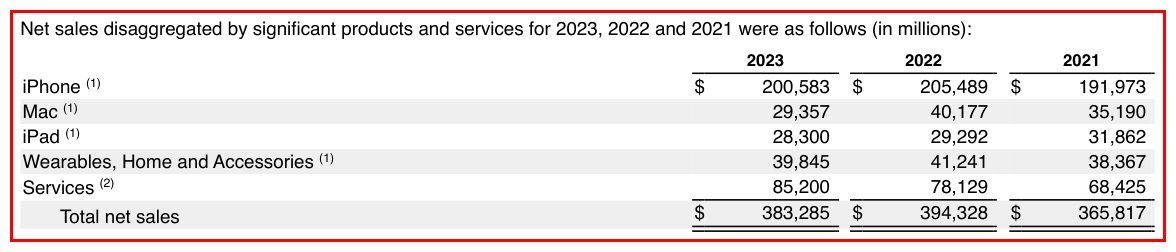

--------------------------------------------------------------------------------

  Result 2 (similarity=0.412):
   Chunk ID: 1680bdb4-fb88-40fb-b2d1-a13db9f47952
   Type: text, Page: 31
   Text preview: <a id='1680bdb4-fb88-40fb-b2d1-a13db9f47952'></a>

Americas
Americas net sales decreased 4% or $7.1 billion during 2023 compared to 2022 due to lower net sales of iPhone and Mac, partially offset by h...

 Dynamically extracting chunk from PDF...
Text chunk (cropped):


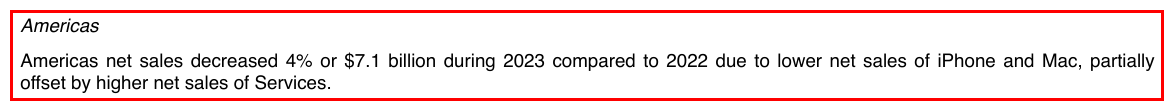

--------------------------------------------------------------------------------

  Result 3 (similarity=0.372):
   Chunk ID: c4cab23c-f3f2-423b-9833-eb64e2112086
   Type: text, Page: 32
   Text preview: <a id='c4cab23c-f3f2-423b-9833-eb64e2112086'></a>

Mac
Mac net sales decreased 27% or $10.8 billion during 2023 compared to 2022 due primarily to lower net sales of laptops....

 Dynamically extracting chunk from PDF...
Text chunk (cropped):


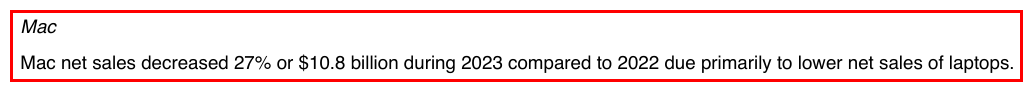

--------------------------------------------------------------------------------

  Result 4 (similarity=0.340):
   Chunk ID: a53a753e-4f90-43b2-9c57-e871cb2c8962
   Type: table, Page: 32
   Text preview: <a id='a53a753e-4f90-43b2-9c57-e871cb2c8962'></a>

Products and Services Performance
The following table shows net sales by category for 2023, 2022 and 2021 (dollars in millions):
<table id="32-1">
<t...

 Dynamically extracting chunk from PDF...
Table chunk (cropped):


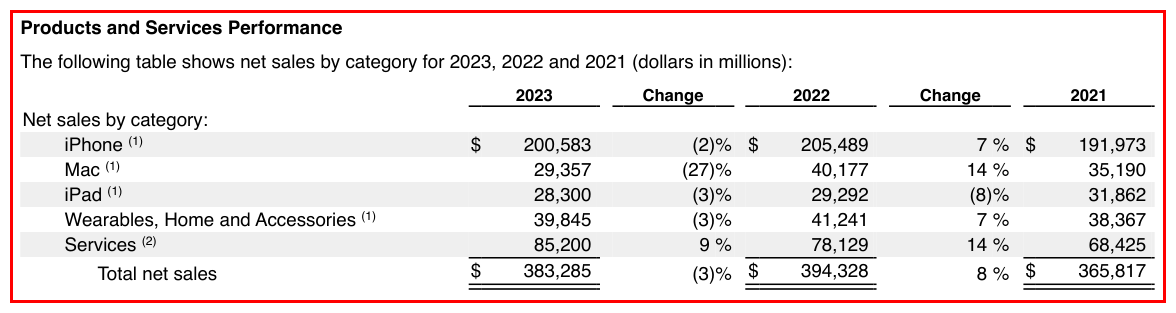

--------------------------------------------------------------------------------

  Result 5 (similarity=0.332):
   Chunk ID: 22aed353-b513-4038-a889-a3ff83dfeca5
   Type: text, Page: 30
   Text preview: <a id='22aed353-b513-4038-a889-a3ff83dfeca5'></a>

The Company's total net sales decreased 3% or $11.0 billion during 2023 compared to 2022. The weakness in foreign currencies relative to the U.S. dol...

 Dynamically extracting chunk from PDF...
Text chunk (cropped):


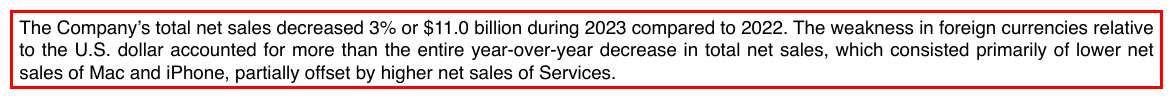

--------------------------------------------------------------------------------


{'ids': [['b9e60fb1-7134-4f52-bbd1-97db6168ddbd',
   '1680bdb4-fb88-40fb-b2d1-a13db9f47952',
   'c4cab23c-f3f2-423b-9833-eb64e2112086',
   'a53a753e-4f90-43b2-9c57-e871cb2c8962',
   '22aed353-b513-4038-a889-a3ff83dfeca5']],
 'embeddings': None,
 'documents': [['<a id=\'b9e60fb1-7134-4f52-bbd1-97db6168ddbd\'></a>\n\nNet sales disaggregated by significant products and services for 2023, 2022 and 2021 were as follows (in millions):\n<table id="46-1">\n<tr><td id="46-2"></td><td id="46-3">2023</td><td id="46-4">2022</td><td id="46-5">2021</td></tr>\n<tr><td id="46-6">iPhone (1)</td><td id="46-7">200,583</td><td id="46-8">205,489</td><td id="46-9">191,973</td></tr>\n<tr><td id="46-a">Mac (1)</td><td id="46-b">29,357</td><td id="46-c">40,177</td><td id="46-d">35,190</td></tr>\n<tr><td id="46-e">iPad (1)</td><td id="46-f">28,300</td><td id="46-g">29,292</td><td id="46-h">31,862</td></tr>\n<tr><td id="46-i">Wearables, Home and Accessories (1)</td><td id="46-j">39,845</td><td id="46-k">41,241</

In [10]:
# Pass in Question in Natural Language, Top_K, and Threshold/L2 Distance
rag_query("What was Apple’s net sales in 2023?", 
          top_k=5, 
          threshold=0.32)

<a id="5"></a>

## 5. Hybrid Search

Semantic search retrieves chunks according to similarity. Hybrid search adds metadata filtering using the `where` parameter.

For example, when asking about revenue figures, search only tables since financial data is typically tabular. This avoids retrieving narrative text that mentions revenue in passing.

In [11]:
q_embed = openai.embeddings.create(
    model=EMBEDDING_MODEL,
    input="What was Apple’s total revenue in 2023?",
).data[0].embedding

results = collection.query(
    query_embeddings=[q_embed],
    n_results=5,
    include=["documents", "metadatas", "distances"],
    where = {"chunk_type": "table"},
)

results["documents"]

[['<a id=\'b9e60fb1-7134-4f52-bbd1-97db6168ddbd\'></a>\n\nNet sales disaggregated by significant products and services for 2023, 2022 and 2021 were as follows (in millions):\n<table id="46-1">\n<tr><td id="46-2"></td><td id="46-3">2023</td><td id="46-4">2022</td><td id="46-5">2021</td></tr>\n<tr><td id="46-6">iPhone (1)</td><td id="46-7">200,583</td><td id="46-8">205,489</td><td id="46-9">191,973</td></tr>\n<tr><td id="46-a">Mac (1)</td><td id="46-b">29,357</td><td id="46-c">40,177</td><td id="46-d">35,190</td></tr>\n<tr><td id="46-e">iPad (1)</td><td id="46-f">28,300</td><td id="46-g">29,292</td><td id="46-h">31,862</td></tr>\n<tr><td id="46-i">Wearables, Home and Accessories (1)</td><td id="46-j">39,845</td><td id="46-k">41,241</td><td id="46-l">38,367</td></tr>\n<tr><td id="46-m">Services (2)</td><td id="46-n">85,200</td><td id="46-o">78,129</td><td id="46-p">68,425</td></tr>\n<tr><td id="46-q">Total net sales</td><td id="46-r">$ 383,285</td><td id="46-s">$ 394,328</td><td id="46-t"

<a id="6"></a>

## 6. RAG 

Combine retrieval with generation using LangChain. The `create_retrieval_chain` builds a pipeline that:
1. Takes a user question
2. Retrieves relevant chunks from the vector store
3. Formats them as context for the LLM
4. Generates a grounded answer

This abstracts the manual embedding and querying steps into a reusable chain.

First, wrap the ChromaDB collection with LangChain's `Chroma` class to get a retriever interface:

In [12]:
vectordb = Chroma(
    collection_name=COLLECTION_NAME,
    embedding_function=OpenAIEmbeddings(model = EMBEDDING_MODEL),
    persist_directory=str(CHROMA_DB_PATH)
)

retriever = vectordb.as_retriever()

Create the RAG chain with a prompt template. The `{context}` placeholder will be filled with retrieved chunks:

<p style="background-color:#f7fff8; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px"> 🚨
&nbsp; <b>Different Run Results:</b> The output generated by AI chat models can vary with each execution due to their non-deterministic nature. Don't be surprised if your results differ from those shown in the video.</p>

In [13]:
# Define prompt template
system_prompt = (
    "Use the following pieces of retrieved context to answer the "
    "user's question. "
    "If you don't know the answer, say that you don't know."
    "\n\n"
    "{context}"
)
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)

# Initialize LLM
llm = ChatOpenAI(model="gpt-5-mini", temperature = 1)

# Create the RAG chain
rag_chain = create_retrieval_chain(retriever, prompt | llm)

# Invoke the chain (conceptual)
response = rag_chain.invoke({"input": 
                             "What were Apple net sales in 2023"})
print(response["answer"])


content="Apple's total net sales in 2023 were $383,285 million (about $383.3 billion)." response_metadata={'token_usage': {'completion_tokens': 96, 'prompt_tokens': 1612, 'total_tokens': 1708, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 64, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-mini', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None} id='run-0e7d2ebc-db3d-41ed-b44a-bdf4de68344f-0'


Try a question requiring understanding trends across years:

In [14]:
# Invoke the chain (conceptual)
response = rag_chain.invoke({
    "input": "How did total revenue trend between 2023 and 2022" 
                                       "for iPhone sales?"})
print(response["answer"])

content='iPhone net sales fell between 2022 and 2023 — from $205,489 million in 2022 to $200,583 million in 2023, a decline of about $4,906 million (≈2%). The company attributed the drop mainly to lower sales of non‑Pro iPhone models, partly offset by higher Pro model sales.' response_metadata={'token_usage': {'completion_tokens': 274, 'prompt_tokens': 1661, 'total_tokens': 1935, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 192, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-mini', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None} id='run-8cd0f281-a56e-4b41-830e-9d112064428d-0'


## Summary

You built a complete RAG pipeline using ADE-parsed documents:

| Step | Component | Purpose |
|------|-----------|--------|
| **Parse** | ADE Parse API | Convert PDF to structured chunks with metadata |
| **Embed** | OpenAI `text-embedding-3-small` | Convert text to 1536-dim vectors |
| **Store** | ChromaDB | Persist vectors with metadata for fast retrieval |
| **Query** | Similarity Search | Find chunks semantically similar to query |
| **Retrieve** | Hybrid Search | Narrow results by chunk type, page, etc. |
| **Generate** | LangChain RAG Chain | Ground LLM answers in retrieved context |

Additionally, you learned to **verify** retrieved information and generated responses through visual grounding.

In our next lesson, we will learn to deploy ADE in the cloud — scaling our RAG application through an event-driven architecture that automatically triggers ADE for document processing whenever new documents appear. This lab helped us understand the logic that will drive our production-ready pipeline. Everything you learned here about embeddings, similarity search, threshold tuning, and metadata filtering transfers directly to Lesson 6. 